In [1]:
# %% Imports
from jax import random, numpy as jnp

from modax.data.kdv import DoubleSoliton
from modax.models import DeepmodBayes
from flax import optim
from modax.losses.bayesian import loss_fn_mse_precalc
from modax.training import train_probabilistic_mse, train_probabilistic_simple
from conditional_gaussian import *
from modax.losses.utils import mse

from modax.linear_model import ridge

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# %% Making data
key = random.PRNGKey(42)

x = jnp.linspace(-10, 10, 100)
t = jnp.linspace(0.1, 1.0, 10)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")

u = DoubleSoliton(x_grid, t_grid, c=[5.0, 2.0], x0=[0.0, -5.0])

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y = u.reshape(-1, 1)
y += 0.1 * jnp.std(y) * random.normal(key, y.shape)

u = (u )/ jnp.std(y)
y = (y )/ jnp.std(y)


In [3]:
model = DeepmodBayes([30, 30, 30, 1])
variables = model.init(key, X)

optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
state, params = variables.pop("params")
optimizer = optimizer.create(params)

In [18]:
# only train mse, stop at minimum mse testset
optimizer, state = train_probabilistic_mse(
    model,
    optimizer,
    state,
    loss_fn_mse_precalc,
    X,
    y,
    max_epochs=1e4,
    split=0.8,
    rand_seed=42,
)

Loss step 0.0: 325.1274719238281
Loss step 1000.0: -203.9407501220703
Loss step 2000.0: -257.2730712890625
Loss step 3000.0: -292.74371337890625
Loss step 4000.0: -344.0791320800781
Loss step 5000.0: -400.7048645019531


In [4]:
variables = {"params": optimizer.target, **state}
prediction, dt, theta, coeffs, _ = model.apply(variables, X, mutable=list(state.keys()))[0]

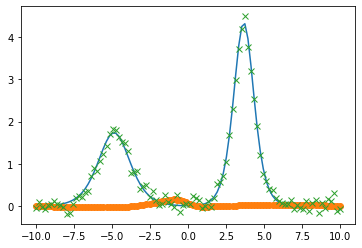

In [5]:
frame = 5
plt.plot(x, u[frame, :])
plt.plot(x, prediction.reshape(x_grid.shape)[frame, :], 'o')
plt.plot(x, y.reshape(x_grid.shape)[frame, :], 'x')

In [18]:
dt_normed = dt / jnp.linalg.norm(dt)
theta_normed = theta / jnp.linalg.norm(theta, axis=0)

coeffs_normed = jnp.linalg.lstsq(theta_normed, dt_normed)[0]

In [15]:
jnp.mean((y - prediction))

DeviceArray(0.60641944, dtype=float32)

In [7]:
jnp.std((y - prediction))

DeviceArray(1.0111945, dtype=float32)

In [12]:
# Now lets look at the std repaorted by the model for two terms:

In [ ]:
jnp.mean()

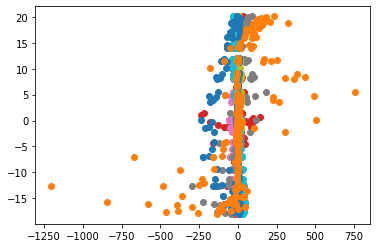

In [47]:
#plt.scatter(theta @ coeffs, dt)
plt.plot(theta, theta @ coeffs, 'o')
#plt.plot(theta, dt, 'x')

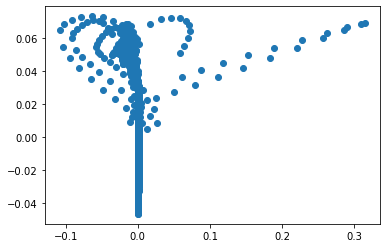

In [16]:
plt.scatter(theta_normed[:, 3], dt_normed)

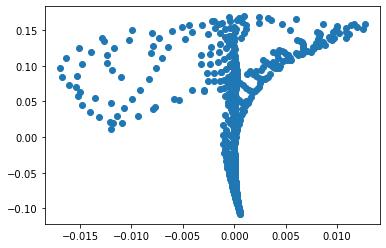

In [10]:
plt.scatter(theta[:, 5], dt)

In [11]:
jnp.std((dt - theta @ coeffs))

DeviceArray(0.03721916, dtype=float32)

In [12]:
jnp.corrcoef(jnp.concatenate([dt / jnp.std(dt), (theta @ coeffs) /jnp.std(theta @ coeffs)], axis=1).T)

DeviceArray([[1.        , 0.81970876],
             [0.8197088 , 1.        ]], dtype=float32)

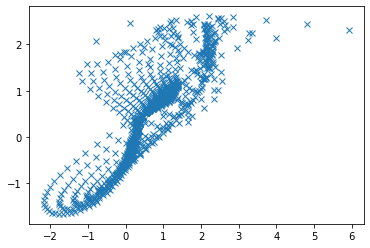

In [13]:
plt.plot((theta @ coeffs) /jnp.std(theta @ coeffs) , dt / jnp.std(dt), 'x')

In [34]:
res_reg = ((dt-theta @ coeffs)).squeeze()
res_mse = ((y - prediction)).squeeze()

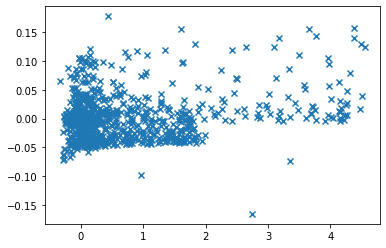

In [37]:
plt.scatter(res_mse, res_reg, marker='x')

In [20]:
jnp.std(dt)

DeviceArray(0.06497981, dtype=float32)

In [55]:
jnp.std(theta @ coeffs)

DeviceArray(5.1012025, dtype=float32)

In [21]:
jnp.std(dt_normed - theta_normed @ coeffs_normed)

DeviceArray(0.01333587, dtype=float32)

In [44]:
X = 
u = ((dt - theta @ coeffs)**2).squeeze()


In [52]:
gram_inv = jnp.linalg.inv(theta.T @ theta)

In [54]:
coeffs_adjusted = gram_inv @ theta.T @ jnp.diag(u) @ theta @ gram_inv

In [55]:
coeffs_adjusted

DeviceArray([[ 1.64368726e-06, -3.03464058e-05, -8.74128182e-06,
              -6.03857188e-06, -5.05476146e-06, -7.77899986e-05,
               7.15557253e-05,  6.70843292e-09, -2.94697355e-04,
               4.49066423e-03, -2.53572408e-03,  9.80946468e-04],
             [-3.03463767e-05,  1.26623511e-02,  3.90895689e-03,
               1.11092092e-03, -2.93779420e-03, -2.66138911e-01,
              -5.21016195e-02, -1.88102424e-02,  3.09271663e-02,
               1.19688189e+00,  2.63457030e-01,  5.44716194e-02],
             [-8.74128455e-06,  3.90895968e-03,  2.98365951e-03,
               3.37686273e-04, -5.72981895e-04, -1.07546009e-01,
              -1.40177086e-02, -1.13462284e-02,  3.39622423e-03,
               5.74640691e-01, -4.12102938e-02,  6.12561107e-02],
             [-6.03858189e-06,  1.11091963e-03,  3.37685342e-04,
               4.27436171e-04, -5.11824503e-04, -1.07411873e-02,
              -9.46274400e-03, -5.18486323e-03,  6.39641006e-03,
              -6.21501

In [57]:
a = {"params": 1}

In [60]:
a.pop("variables")

KeyError: 'variables'